In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../logs/custom_arch/arch_params.csv')

selected_region = 'OTC'
selected_metric = 'srpr'

df = df[(df['region'] == selected_region) & (df['metric'] == selected_metric) & (df['norm'] != 'instance')]

In [30]:
df['score'].max()

'0.21863870322704315'

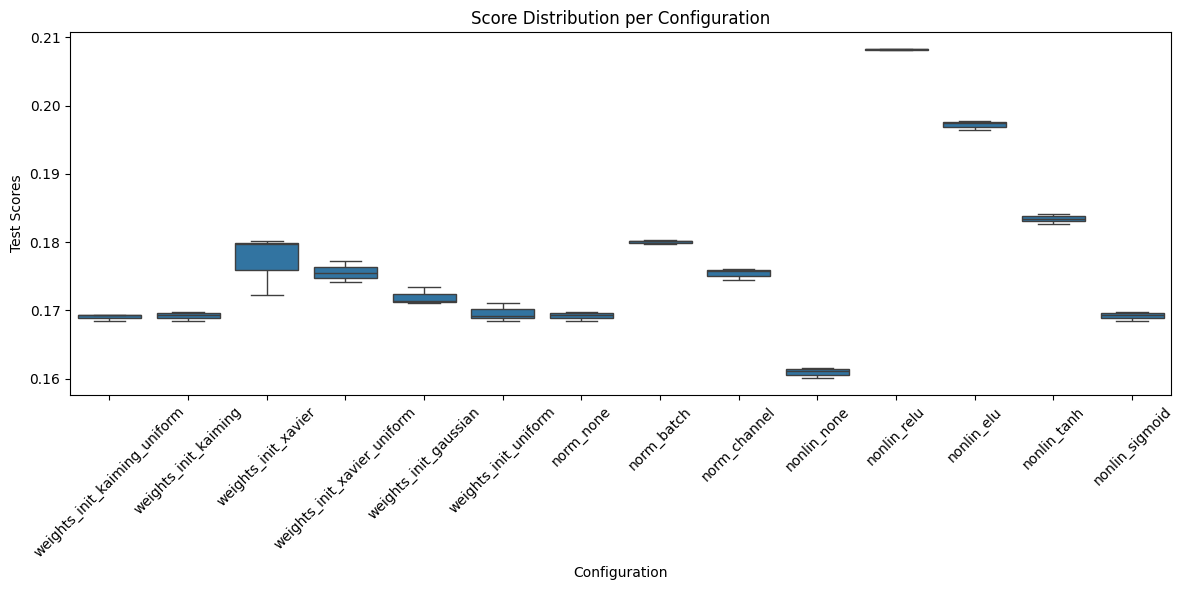

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already filtered by 'region' and 'metric'
df['score'] = pd.to_numeric(df['score'], errors='coerce')

default = {
    "weights_init": "kaiming",
    "norm": "none",
    "nonlin": "sigmoid"
}

# Get unique values
weights_inits = df['weights_init'].unique()
norms = df['norm'].unique()
nonlins = df['nonlin'].unique()

def prepare_data(config_name, config_values, other_defaults):
    frames = []
    for value in config_values:
        query = " & ".join([f"{k} == '{v}'" for k, v in other_defaults.items()]) + f" & {config_name} == '{value}' & cv_split == 'test'"
        temp_df = df.query(query).copy()  # Using .copy() to avoid SettingWithCopyWarning
        temp_df['config'] = f"{config_name}_{value}"
        frames.append(temp_df)
    return pd.concat(frames)

# Preparing data
df_weights_init = prepare_data('weights_init', weights_inits, {"norm": default["norm"], "nonlin": default["nonlin"]})
df_norm = prepare_data('norm', norms, {"weights_init": default["weights_init"], "nonlin": default["nonlin"]})
df_nonlin = prepare_data('nonlin', nonlins, {"weights_init": default["weights_init"], "norm": default["norm"]})

# Combine all data for plotting
df_plot = pd.concat([df_weights_init, df_norm, df_nonlin])

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='config', y='score', data=df_plot)
plt.xticks(rotation=45)
plt.title('Score Distribution per Configuration')
plt.ylabel('Test Scores')
plt.xlabel('Configuration')
plt.tight_layout()
plt.show()


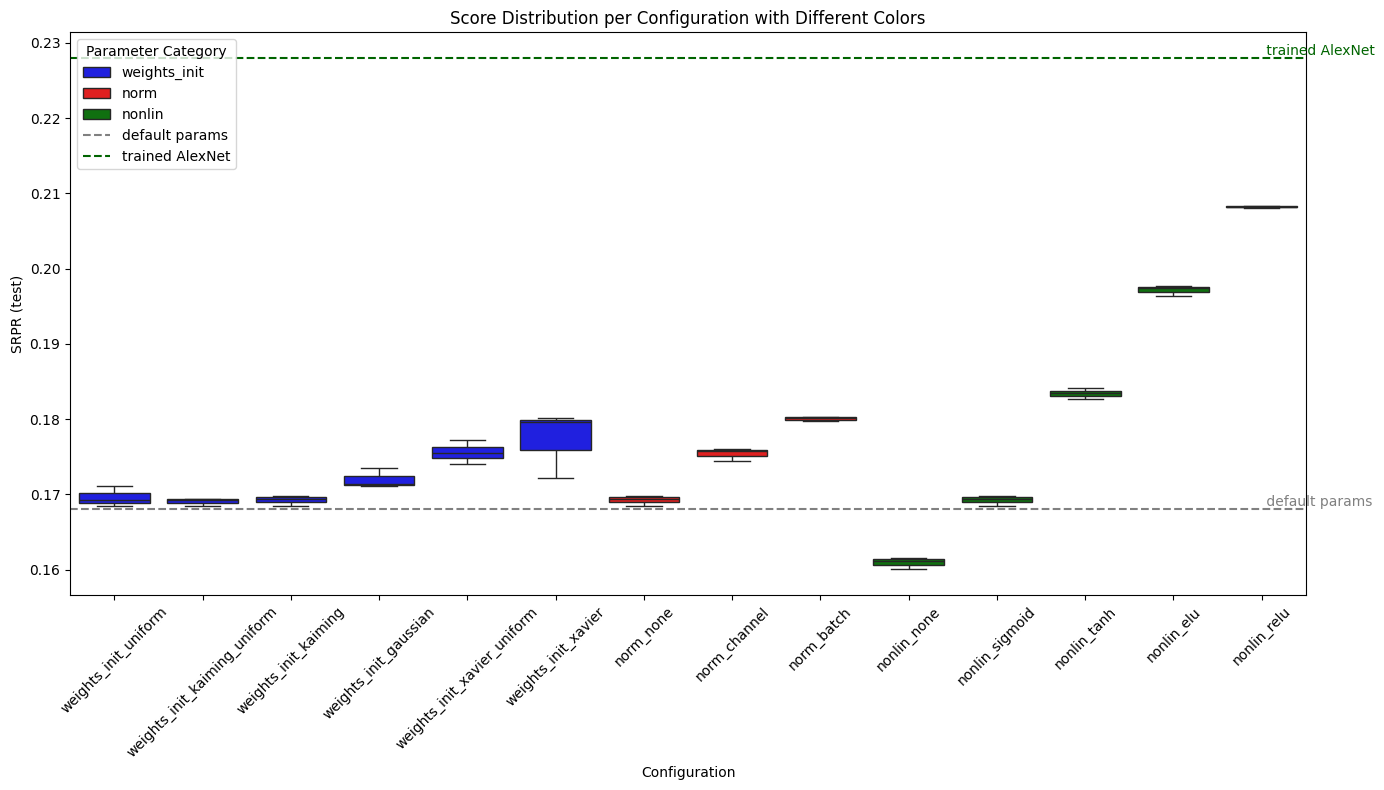

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already filtered by 'region' and 'metric'
df['score'] = pd.to_numeric(df['score'], errors='coerce')

default = {
    "weights_init": "kaiming",
    "norm": "none",
    "nonlin": "sigmoid"
}

# Get unique values
weights_inits = df['weights_init'].unique()
norms = df['norm'].unique()
nonlins = df['nonlin'].unique()

def prepare_data(config_name, config_values, other_defaults):
    frames = []
    for value in config_values:
        query = " & ".join([f"{k} == '{v}'" for k, v in other_defaults.items()]) + f" & {config_name} == '{value}' & cv_split == 'test'"
        temp_df = df.query(query).copy()  # Using .copy() to avoid SettingWithCopyWarning
        temp_df['config'] = f"{config_name}_{value}"
        temp_df['param_category'] = config_name  # For coloring by parameter category
        frames.append(temp_df)
    return pd.concat(frames)

# Preparing data
df_weights_init = prepare_data('weights_init', weights_inits, {"norm": default["norm"], "nonlin": default["nonlin"]})
df_norm = prepare_data('norm', norms, {"weights_init": default["weights_init"], "nonlin": default["nonlin"]})
df_nonlin = prepare_data('nonlin', nonlins, {"weights_init": default["weights_init"], "norm": default["norm"]})

# Combine all data for plotting
df_plot = pd.concat([df_weights_init, df_norm, df_nonlin])

# Sorting configurations within each parameter by median score
df_plot['median_score'] = df_plot.groupby('config')['score'].transform('median')

# Separate sort and combine
df_weights_init_sorted = df_plot[df_plot['param_category'] == 'weights_init'].sort_values('median_score')
df_norm_sorted = df_plot[df_plot['param_category'] == 'norm'].sort_values('median_score')
df_nonlin_sorted = df_plot[df_plot['param_category'] == 'nonlin'].sort_values('median_score')

df_plot_sorted = pd.concat([df_weights_init_sorted, df_norm_sorted, df_nonlin_sorted])

# Plotting with color distinction
plt.figure(figsize=(14, 8))
palette = {'weights_init': 'b', 'norm': 'r', 'nonlin': 'g'}
sns.boxplot(x='config', y='score', hue='param_category', palette=palette, data=df_plot_sorted, dodge=False)
plt.xticks(rotation=45)

# Adding horizontal lines and labels
plt.axhline(y=0.168, color='gray', linestyle='--', label='default params')
plt.text(x=df_plot_sorted['config'].nunique()-1, y=0.168, s=' default params', verticalalignment='bottom', color='gray')

plt.axhline(y=0.228, color='darkgreen', linestyle='--', label='trained AlexNet')
plt.text(x=df_plot_sorted['config'].nunique()-1, y=0.228, s=' trained AlexNet', verticalalignment='bottom', color='darkgreen')

plt.title('Score Distribution per Configuration with Different Colors')
plt.ylabel('SRPR (test)')
plt.xlabel('Configuration')

# Adjust legend position to top left
plt.legend(title='Parameter Category', loc='upper left')

plt.tight_layout()
plt.savefig('params.png', dpi=500)